In [145]:
import hicstraw
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [155]:
GM12878 = hicstraw.HiCFile("data/GM12878.hic")
stuff = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10",
 "11", "12", "13", "14", "15", "16", "17", "18", "19", "20",
 "21", "22", "X"]


In [183]:
mzd_GM12878 = GM12878.getMatrixZoomData("1", "1", "observed", "NONE", "BP", 5000)
record_list_GM12878 = mzd_GM12878.getRecords(0, GM12878.getChromosomes()[0].length, 0, GM12878.getChromosomes()[0].length)

[2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0]

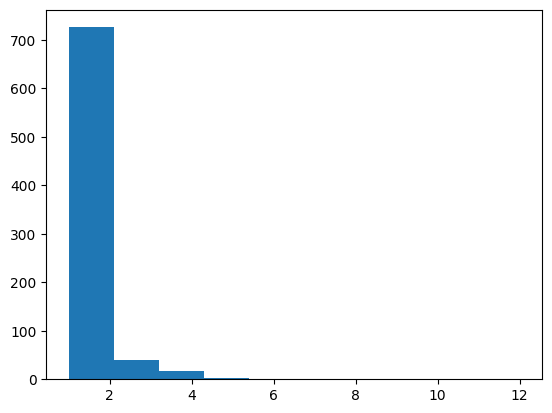

In [184]:
plt.hist([
    r.counts for r in record_list_GM12878
])
[
    r.counts for r in record_list_GM12878
][:10]

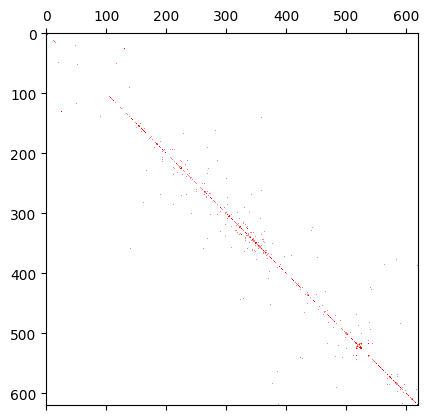

In [185]:
from matplotlib.colors import LinearSegmentedColormap
REDMAP = LinearSegmentedColormap.from_list("bright_red", [(1,1,1),(1,0,0)])
# helper function for plotting
def plot_hic_map(dense_matrix, maxcolor):
    plt.matshow(dense_matrix, cmap=REDMAP, vmin=0, vmax=maxcolor)
    plt.show()

plot_hic_map(
    mzd_GM12878.getRecordsAsMatrix(0, GM12878.getChromosomes()[0].length, 0, GM12878.getChromosomes()[0].length),
    2
)

In [188]:
def cd_tad(data, threshold=0):
    df_list = []
    for chr in data.getChromosomes():
        if chr.name in stuff:
            print(f"Processing chr{chr.name}")
            mzd = data.getMatrixZoomData(chr.name, chr.name, "observed", "NONE", "BP", 5000)
            record_list = mzd.getRecords(0, chr.length, 0, chr.length)
            g = nx.Graph()
            g.add_weighted_edges_from([(r.binX, r.binY, r.counts) for r in record_list if r.counts > threshold])
            comms = nx.community.louvain_communities(g)
            lod = [
                {"chr":chr.name, "bin": bin, "community": f"{chr.name}_{comm_i}"}
                for comm_i, comm in enumerate(comms)
                for bin in comm 
            ]
            df = pd.DataFrame(lod)
            df_list.append(df)
    return pd.concat(df_list).reset_index()

In [189]:
df_all = cd_tad(GM12878)

Processing chr1
Processing chr2
Processing chr3
Processing chr4
Processing chr5
Processing chr6
Processing chr7
Processing chr8
Processing chr9
Processing chr10
Processing chr11
Processing chr12
Processing chr13
Processing chr14
Processing chr15
Processing chr16
Processing chr17
Processing chr18
Processing chr19
Processing chr20
Processing chr21
Processing chr22
Processing chrX


In [130]:
import numpy as np

In [132]:
np.gradient(df_all[df_all["chr"] == "1"]["bin"])

array([ 6400000.,  6400000.,   362500., ..., -3200000.,  3562500.,
       10325000.])

In [220]:
df_select = df_all[df_all["community"] == "10_2"].sort_values("bin")

In [221]:
gradient = np.gradient(df_select["bin"])/5000

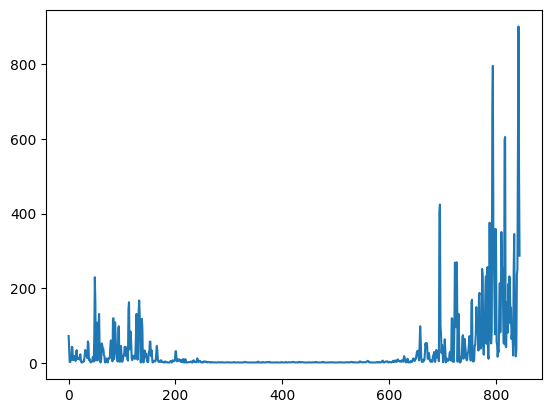

In [222]:
plt.plot(gradient)

In [303]:
def trim_communities_to_tads_window(df):
    df.loc[:, "tad"] = -1
    if len(df) < 10:
        return df
    MAX_JUMP_BINS = 50
    TAD_SIZE_MIN_INTERACTIONS = 50
    BIN_SIZE = 5000
    df = df.sort_values("bin").reset_index(drop=True)
    gradient = np.gradient(df["bin"])/BIN_SIZE
    jumps, = np.where(gradient > MAX_JUMP_BINS)
    for i, (start, end) in enumerate(zip(jumps[:-1], jumps[1:])):
        if len(df.loc[start:end, "tad"]) > TAD_SIZE_MIN_INTERACTIONS:
            df.loc[start:end, "tad"] = i
    return df

In [304]:
df_all.groupby("community").apply(trim_communities_to_tads_window, include_groups=False)

/tmp/ipykernel_5719/152096158.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_all.groupby("community").apply(trim_communities_to_tads_window)


index chr        bin community  tad
community                                            
10_0      313943      0  10    1515000      10_0   -1
10_1      313944      1  10    1305000      10_1   -1
          313945      2  10    1320000      10_1   -1
10_10     314919    976  10    1485000     10_10   -1
10_100    315318   1375  10    8675000    10_100   -1
...                 ...  ..        ...       ...  ...
X_999     180     17045   X  142770000     X_999   -1
          181     16936   X  143935000     X_999   -1
          182     16950   X  143955000     X_999   -1
          183     17095   X  143960000     X_999   -1
          184     17089   X  144750000     X_999   -1

[553511 rows x 5 columns]

In [305]:
a = _

In [306]:
a[a["tad"] > 0]

index chr        bin community  tad
community                                         
10_1076   91   21873  10   79990000   10_1076   46
          92   22030  10   80485000   10_1076   46
          93   21971  10   80490000   10_1076   46
          94   21925  10   80495000   10_1076   46
          95   21850  10   80505000   10_1076   46
...              ...  ..        ...       ...  ...
X_998     179  16866   X  149020000     X_998   70
          180  16858   X  149085000     X_998   70
          181  16892   X  149145000     X_998   70
          182  16861   X  149170000     X_998   70
          183  16878   X  149275000     X_998   70

[187912 rows x 5 columns]

In [317]:
def trim_communities_to_tads(df):
    df.loc[:, "tad"] = -1
    if len(df) < 10:
        return pd.DataFrame({"start": [], "end": []})
    MAX_JUMP_BINS = 50
    TAD_SIZE_MIN_INTERACTIONS = 50
    BIN_SIZE = 5000
    df = df.sort_values("bin").reset_index(drop=True)
    gradient = np.gradient(df["bin"])/BIN_SIZE
    jumps, = np.where(gradient > MAX_JUMP_BINS)
    tad_list = []
    for i, (start, end) in enumerate(zip(jumps[:-1], jumps[1:])):
        if len(df.loc[start:end, "tad"]) > TAD_SIZE_MIN_INTERACTIONS:
            tad_list.append({"start": start * BIN_SIZE, "end": end * BIN_SIZE})
    return pd.DataFrame(tad_list)

In [318]:
result = df_all.groupby("community").apply(trim_communities_to_tads, include_groups=False)

In [337]:
result.reset_index()

,community,level_1,start,end
0,10_1076,0,455000.0,1075000.0
1,10_1110,0,520000.0,2850000.0
2,10_1129,0,820000.0,2005000.0
3,10_1135,0,1150000.0,2535000.0
4,10_1170,0,375000.0,675000.0
...,...,...,...,...
739,X_1980,0,605000.0,855000.0
740,X_200,0,1005000.0,1520000.0
741,X_50,0,50000.0,370000.0
742,X_562,0,695000.0,1080000.0
